In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report

In [2]:
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Define the directories for Ferromagnetic and Paramagnetic data
ferromagnetic_dir = os.path.join(notebook_dir, "Ferromagnetic")
paramagnetic_dir = os.path.join(notebook_dir, "Paramagnetic")

In [3]:
comp = ''
dim = 10
steps = 10**6
train_per_label = 3000
ind_test_per_temp = 500

In [4]:
# Load data
ferromagnetic_data = [np.load(os.path.join(ferromagnetic_dir, file)) for file in os.listdir(ferromagnetic_dir) if file.endswith('.npy')]
paramagnetic_data = [np.load(os.path.join(paramagnetic_dir, file)) for file in os.listdir(paramagnetic_dir) if file.endswith('.npy')]

In [5]:
# Create labels
ferromagnetic_labels = np.ones(len(ferromagnetic_data))
paramagnetic_labels = np.zeros(len(paramagnetic_data))

In [6]:
# Combine data and labels
data = np.concatenate([ferromagnetic_data, paramagnetic_data], axis=0)
labels = np.concatenate([ferromagnetic_labels, paramagnetic_labels], axis=0)

In [7]:
# Get the dimensions of the data
x_dim, y_dim, z_dim, _ = data.shape[1:]

# Convert the data to a 4D array
data = data.reshape(-1, x_dim, y_dim, z_dim, 3)

In [8]:
# Split the data into training, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_dim, y_dim, z_dim, 3)),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Use linear activation for regression
])

In [10]:
# Compile the model with Mean Squared Error (MSE) loss
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
132/132 [==============================] - 4s 20ms/step - loss: 0.0175 - accuracy: 0.9819 - val_loss: 2.2447e-05 - val_accuracy: 1.0000
Epoch 2/10
132/132 [==============================] - 2s 18ms/step - loss: 1.5618e-05 - accuracy: 1.0000 - val_loss: 1.0525e-05 - val_accuracy: 1.0000
Epoch 3/10
132/132 [==============================] - 2s 18ms/step - loss: 1.0447e-05 - accuracy: 1.0000 - val_loss: 8.8909e-06 - val_accuracy: 1.0000
Epoch 4/10
132/132 [==============================] - 2s 18ms/step - loss: 7.8524e-06 - accuracy: 1.0000 - val_loss: 5.7154e-06 - val_accuracy: 1.0000
Epoch 5/10
132/132 [==============================] - 2s 19ms/step - loss: 1.1048e-05 - accuracy: 1.0000 - val_loss: 7.3484e-06 - val_accuracy: 1.0000
Epoch 6/10
132/132 [==============================] - 2s 18ms/step - loss: 6.1966e-06 - accuracy: 1.0000 - val_loss: 4.2561e-06 - val_accuracy: 1.0000
Epoch 7/10
132/132 [==============================] - 2s 19ms/step - loss: 7.4232e-06 - accuracy: 

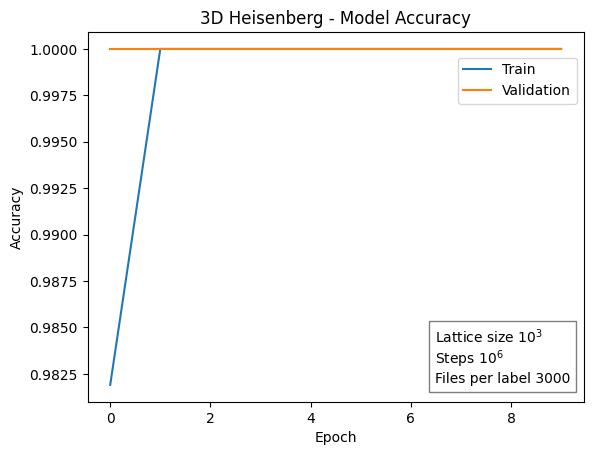

In [12]:
# Visualize the performance of training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('3D Heisenberg - Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

pow = str(steps).count('0')
labels = [f'Lattice size ${dim}^3$', f'Steps $10^{pow}$', f'Files per label {train_per_label}']

plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 0.95))

# Adding a box inside the plot with additional information
additional_info = '\n'.join(labels)
plt.text(0.7, 0.05, additional_info, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

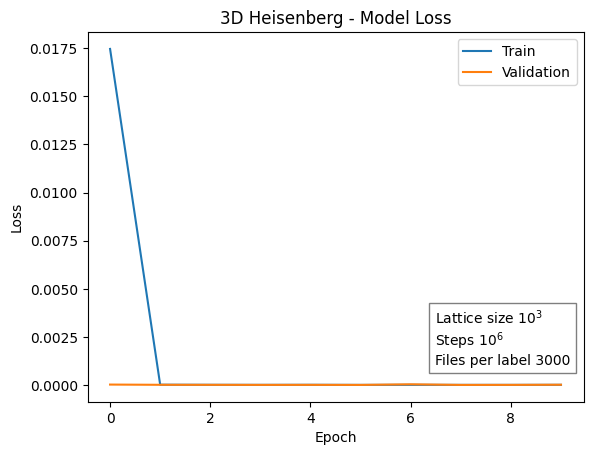

In [13]:
# Visualize the performance of training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('3D Heisenberg - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 1))
plt.text(0.7, 0.1, additional_info, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

29/29 [==============================] - 0s 4ms/step - loss: 1.4064e-05 - accuracy: 1.0000
Test Loss: 1.406379942636704e-05
Test Accuracy: 1.0


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Make predictions on the test data
predictions = model.predict(X_test)
# Calculate accuracy and classification report
threshold = 0.5  # Threshold for classification
predicted_labels = (predictions > threshold).astype(int).flatten()
test_accuracy = (predicted_labels == y_test).mean()
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test, predicted_labels))

29/29 [==============================] - 0s 4ms/step
Test Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       440
         1.0       1.00      1.00      1.00       460

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



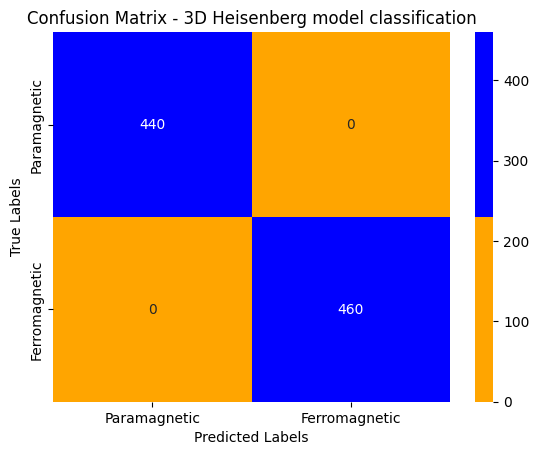

In [16]:
# Define label names
label_names = ['Paramagnetic', 'Ferromagnetic']

# Create confusion matrix
confusion = confusion_matrix(y_test, predicted_labels)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap=ListedColormap(['orange', 'blue']),
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - 3D Heisenberg model classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
# Clear variables that are no longer needed
del X_train, y_train, X_test, y_test, data, labels, history, predictions, predicted_labels
del ferromagnetic_data, paramagnetic_data, ferromagnetic_labels, paramagnetic_labels, X_temp, y_temp, y_val, X_val

In [18]:
import pandas as pd
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Define the directories for Ferromagnetic and Paramagnetic data
directory = os.path.join(notebook_dir, "For Testing")

subdirectories = [subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]

table_data = []

Avg_Predictions = []
for subdir in subdirectories:
    temp = float(subdir)
    if temp == 1.44:
        continue
    if temp < 1.44:
        label = 'Ferromagnetic'
        accuracy_func = lambda acc: acc
    else:
        label = 'Paramagnetic'
        accuracy_func = lambda acc: 100 - acc
    subdir_path = os.path.join(directory, subdir)
    file_names = [file_name for file_name in os.listdir(subdir_path) if file_name.endswith('.npy')]
    num_of_correct_predictions = 0
    num_of_files = 0

    Predictions_at_T = []
    for file_name in file_names:
        file_path = os.path.join(subdir_path, file_name)
        new_data = np.load(file_path)
        new_data = new_data.reshape(1, x_dim, y_dim, z_dim, 3)  # Reshape for model input
        predictions = model.predict(new_data)
        predicted_label = 'Ferromagnetic' if predictions[0][0] > 0.5 else 'Paramagnetic'
        Predictions_at_T.append(predictions[0][0])
        if predicted_label == label:
            num_of_correct_predictions += 1
        num_of_files += 1
        
    Avg_Predictions.append((temp, np.mean(Predictions_at_T), np.std(Predictions_at_T)))


    accuracy = (num_of_correct_predictions / num_of_files) * 100
    orderliness = accuracy_func(accuracy)
    table_data.append((temp, orderliness))

# Create a Pandas DataFrame from the table data
df = pd.DataFrame(table_data, columns=['Temperature', 'Orderliness'])

1/1 [==============================] - 0s 26ms/step


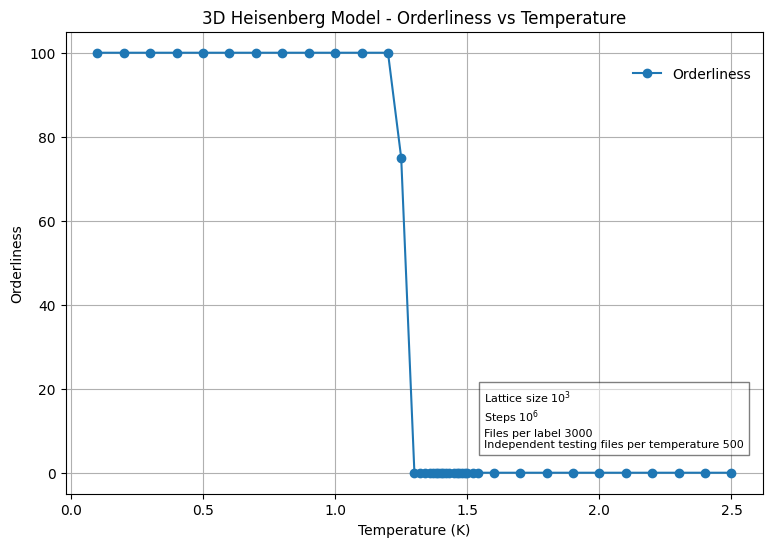

In [19]:
# Sort the DataFrame by Temperature df = df.sort_values(by='Temperature')
# Plot the graph
plt.figure(figsize=(9, 6))
plt.plot(df['Temperature'], df['Orderliness'], marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Orderliness')
plt.title('3D Heisenberg Model - Orderliness vs Temperature')
plt.grid(True)

# Store the graph values in a text file
graph_data = pd.concat([df['Temperature'], df['Orderliness']], axis=1)
graph_data.to_csv('orderliness_vs_temperature.txt', sep='\t', index=False, header=False)

pow = str(steps).count('0')
labels = [f'Lattice size ${dim}^3$', f'Steps $10^{pow}$', f'Files per label {train_per_label}',
          f'Independent testing files per temperature {ind_test_per_temp}']


plt.legend(['Orderliness'], loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95))

# Adding a box inside the plot with additional information
additional_info = '\n'.join(labels)
plt.text(0.6, 0.1, additional_info, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=8)


# Save the graph as an image
plt.savefig('orderliness_vs_temperature.png')

# Display the table
#print(df)
#print(Avg_Predictions)

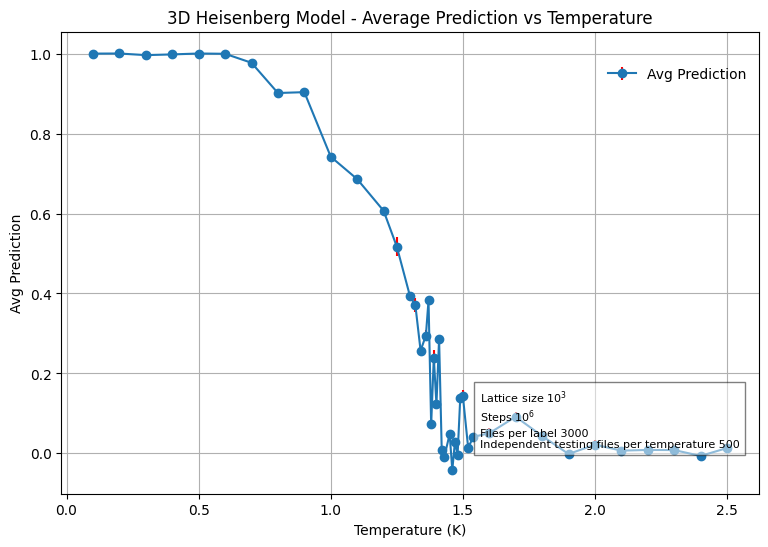

In [20]:
# Create a Pandas DataFrame from the table data
df2 = pd.DataFrame(Avg_Predictions, columns=['Temperature', 'Avg_Predictions', 'Std_Deviation'])

# Sort the DataFrame by Temperature
df2 = df2.sort_values(by='Temperature')

plt.figure(figsize=(9, 6))
# Set the color of vertical error bars to red
plt.errorbar(df2['Temperature'], df2['Avg_Predictions'], yerr=df2['Std_Deviation'], marker='o', ecolor='red')
plt.xlabel('Temperature (K)')
plt.ylabel('Avg Prediction')
plt.title('3D Heisenberg Model - Average Prediction vs Temperature')
plt.grid(True)

# Store the graph values in a text file
graph_data = pd.concat([df2['Temperature'], df2['Avg_Predictions'], df2['Std_Deviation']], axis=1)
graph_data.to_csv('Average_Prediction_vs_temperature.txt', sep='\t', index=False, header=False)

plt.legend(['Avg Prediction'], loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95))

plt.text(0.6, 0.1, additional_info, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=8)

# Display the table
#print(df2)
plt.savefig('Average_Prediction_vs_temperature.png')

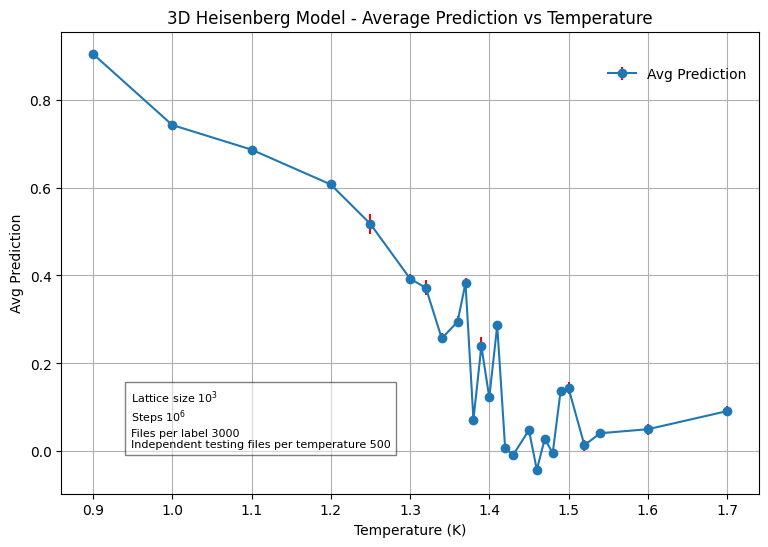

In [21]:
# Create a Pandas DataFrame from the table data
df2 = pd.DataFrame(Avg_Predictions, columns=['Temperature', 'Avg_Predictions', 'Std_Deviation'])

# Sort the DataFrame by Temperature
df2 = df2.sort_values(by='Temperature')

# Define how many data points to drop from each end
num_points_to_drop = 8

# Drop data points from both ends
df2 = df2.iloc[num_points_to_drop:-num_points_to_drop]

plt.figure(figsize=(9, 6))
# Plot the graph
plt.errorbar(df2['Temperature'], df2['Avg_Predictions'], yerr=df2['Std_Deviation'], marker='o', ecolor='red')
plt.xlabel('Temperature (K)')
plt.ylabel('Avg Prediction')
plt.title('3D Heisenberg Model - Average Prediction vs Temperature')
plt.grid(True)

# Store the graph values in a text file
graph_data = pd.concat([df2['Temperature'], df2['Avg_Predictions'], df2['Std_Deviation']], axis=1)
graph_data.to_csv('Average_Prediction_vs_temperature_narrow_band.txt', sep='\t', index=False, header=False)

plt.legend(['Avg Prediction'], loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95))

plt.text(0.1, 0.1, additional_info, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=8)

# Display the table
plt.savefig('Average_Prediction_vs_temperature_narrow_band.png')